# Human body keypoints detection

It is a computer vision technology that enables a computer to determine the pose of any object in an image of the video, which is a collection of moving images. To put it simply, pose estimation is a technology that tells the computer what pose an object is making.

# Openpose 

OpenPose is a Real-time multiple-person detection library, and it’s the first time that any library has shown the capability of jointly detecting human body, face, and foot keypoints. 

# import necessary libraries

In [320]:
import tqdm as tqdm
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [311]:
#lopading the model weights
model = cv.dnn.readNetFromTensorflow('graph_opt.pb')

In [312]:
#Reading the Dataframe
columns_names = ['Images', 'Activity']
image_df = pd.read_csv('labels.csv', names = columns_names)

In [314]:
#reading first 12 row for data visualization
image_df.head()
df = image_df[:12]
df.shape

(12, 2)

# Visualizing the image

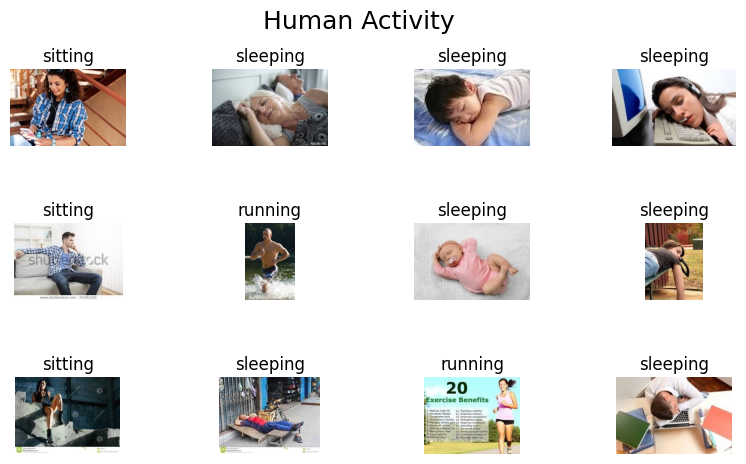

In [315]:
plt.figure(figsize= (10,5))
plt.subplots_adjust(hspace=1)
plt.suptitle("Human Activity", fontsize=18, y=1)

main_path = 'images/'
for i, row in df.iterrows():
    ax = plt.subplot(3,4,i+1)
    image = os.path.join(main_path, row['Images'])
    image = cv.imread(image)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB)) #converting the image from bgr to rgb 
    plt.axis('off')
    plt.title(row['Activity'],fontsize=12)
plt.show()
   

# Extracting keypoints

In [316]:
#Defining the body parts and it's pair
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [99]:
image_width = 368
image_height = 368
thr = .2

In [357]:
#Function definition for extracting keypoints from the image by the model.
#This function is for actual keypoinyts detection

def keypoints_detection(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    model.setInput(cv.dnn.blobFromImage(frame, 1.0, (image_width, image_width), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = model.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 2)
            cv.ellipse(frame, points[idFrom], (2, 2), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (2, 2), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = model.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    return frame

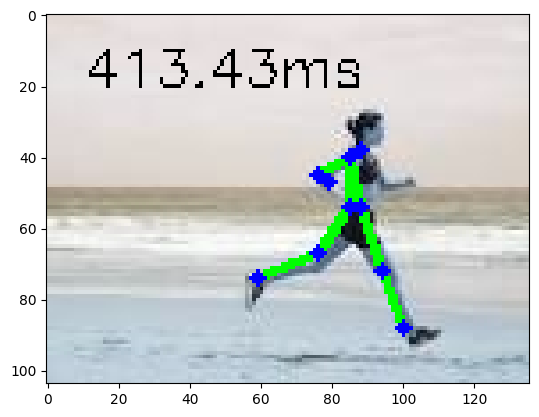

In [358]:
image = 'images/Image_1039.jpg'
image = cv.imread(image)
body_keypoints = keypoints_detection(image)
plt.imshow(body_keypoints)

As dataset is imbalanced and have to apply some SMOTE techniques, which need dataset in proper format but the above function is putting 'None' keypoint is not found, so just for the sake of balacing modified the function slightly and put (0,0), when keypoints is none and after creating the balanced dataset those can be romoved to get newly created dataset.

In [317]:
#Function definition for extracting keypoints from the image by the model.
def body_keypoints_detection(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    model.setInput(cv.dnn.blobFromImage(frame, 1.0, (image_width, image_width), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = model.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        if conf > thr:
            points.append((int(x), int(y)))
        else:
            points.append((0,0))

    del points[-1]
    #points = [pt for pt in points if pt != (0,0)]
    return points

In [323]:
# Extracting body keypoints for all of the images

body_keypoints = []
activity = []
for i, row in image_df.iterrows():
    image = os.path.join(main_path, row['Images'])
    image = cv.imread(image)
    detected_body_keypoints = body_keypoints_detection(image)
    body_keypoints.append(detected_body_keypoints)
    activity.append(row['Activity'])      

In [324]:
#Converting the body key points into a pandas dataframe

df = pd.DataFrame({'Keypoints' : body_keypoints, 
                   'Activity' : activity})

In [326]:
#Converting touple of body key points into list of string
def touple(ls):
    value = ''
    for i in ls:
        value += str(i[0]) + ' '
        value += str(i[1]) + ' '
    return value

key_pt = []
for row in df['Keypoints']:
    key_pt.append(touple(row))  

In [327]:
#Again converting it into dataframe
sample_df  = pd.DataFrame({'Key': key_pt})

#Spliting the Key columns into 36 columns as later we will check wheather it is balanced or not and willy apply smote techniques
df[['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36', '37']] = sample_df.Key.str.split(" ", expand = True)

In [336]:
# #Droping the Keypoints and '37' cplumns
 df.drop(['Keypoints', '37'], axis = 1, inplace=True)

In [333]:
df.to_csv('unbalanced_keypoints.csv', index = False)

In [334]:
df = pd.read_csv('unbalanced_keypoints.csv')
df.head()

,Activity,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,sitting,0,0,88,10,78,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sleeping,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sleeping,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sleeping,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,sitting,144,45,133,65,0,0,0,0,0,...,185,176,138,41,144,41,121,41,0,0


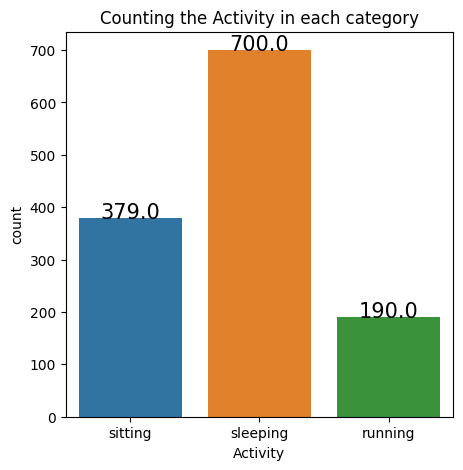

In [337]:
# Counting the total number of unique category.

plt.figure(figsize=(5,5)) 
ax = sns.countplot(x=df['Activity'])
plt.title('Counting the Activity in each category')
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.25,rect.get_height(),horizontalalignment='center', fontsize = 15)

So, here we are seeing that data is greatly imbalanced. And an imbalanced dataset negetivelt impact the model performance. So we have to balnace the dataset using some SMOTE techniques.But before using SMOTE it requires dataset is well formted.

Firstly formated the program in such a way that upto a certain value algorithm will provide the 'None' is key point is not found, But it was returing the the co-ordinate of the keypoints. But we can not keep the dataset in this format,if want ot use the SMOTE techniques. That's why for the sake of blancing add a touple of zero where keypoints is not found.

In [338]:
#Eccoding the target column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])
list(le.inverse_transform([0, 1, 2])) # Reversing the label

['running', 'sitting', 'sleeping']

In [339]:
#Seperating the dependent and independent and dependent variable
X = df.drop(['Activity'], axis=1)
y = df['Activity']

# Data Balancing

## Over sampling

In [340]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE(k_neighbors=1)
#X_train, y_train = smt.fit_resample(X_train, y_train)
Over, y_sm = smt.fit_resample(X, y)

counter = Counter(y_sm)
print('After',counter)

Over['Activity'] =  y_sm
Over.to_csv('Balanced_keypoints_oversampling.csv')

Before Counter({2: 700, 1: 379, 0: 190})
After Counter({1: 700, 2: 700, 0: 700})


## ADASYN

In [342]:
#ADASYN
from imblearn.over_sampling import ADASYN

counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
ADASYN, y_ada = ada.fit_resample(X, y)

counter = Counter(y_ada)
print('After',counter)

ADASYN['Activity'] =  y_sm
ADASYN.to_csv('Balanced_keypoints_ADASYN.csv')

Before Counter({2: 700, 1: 379, 0: 190})
After Counter({2: 700, 0: 685, 1: 673})


## SMOTE + TOMEK

In [343]:
#SMOTE + TOMEK
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
smtom, y_smtom = smtom.fit_resample(X, y)

counter = Counter(y_smtom)
print('After',counter)

smtom['Activity'] =  y_sm
smtom.to_csv('Balanced_keypoints_smtom.csv')

Before Counter({2: 7, 0: 2, 1: 2})
After Counter({0: 693, 2: 679, 1: 676})


## SMOTE+ ENN

In [359]:

from imblearn.combine import SMOTEENN

counter = Counter(y)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
smenn, y_smenn = smenn.fit_resample(X, y)

counter = Counter(y_smenn)
print('After',counter)

smenn['Activity'] =  y_smenn
smenn.to_csv('Balanced_keypoints_smenn.csv')

Before Counter({2: 700, 1: 379, 0: 190})
After Counter({0: 544, 2: 505, 1: 394})


# SMOTE + UNDER SAMPLING

In [367]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
rus =  RandomUnderSampler()

#pipeline = Pipeline(steps = [('smote', sm),('under',rus)])

counter = Counter(y)
print('Before',counter)
#over and undersampling the train dataset using SMOTE + RandomUnderSampler
rus, y_rus = rus.fit_resample(X, y)

counter = Counter(y_rus)
print('After',counter)

smrus['Activity'] =  y_rus
smrus.to_csv('Balanced_keypoints_rus.csv')

Before Counter({2: 700, 1: 379, 0: 190})
After Counter({0: 190, 1: 190, 2: 190})


# N.B

One most important point to note here is that Model could not get the keypoints of sleeping images.It may be just because image is not complete or the quality.